# Bandit Assignment

This assignment should be done in groups of 2 and consists of a number of implementation and theory problems based on the topics discussed in the lectures and the course literature:

[Bandits] *Aleksandrs Slivkins, [Introduction to Multi-Armed Bandits](https://arxiv.org/pdf/1904.07272v5.pdf), Found. Trends Mach. Learn. 12(1-2): 1-286 (2019)*

In the implementation problems **(1, 2, 3 and 5)**, you will implement multi-armed bandit algorithms from the [Bandits] book and use them in a provided multi-armed bandit environment. These problems will be graded based on the correctness of the code.

In the theory problems **(4 and 6)**, you will derive some properties of the algorithms. These problems will be graded based on the correctness of the arguments.

You may use the python libraries imported below (*numpy*, *scipy.stats* and *pandas*).

The assignment should be handed in as an updated notebook. The entire notebook should be run before it is handed in, so that the plots are visible. Ensure that it is completely runnable, in the case that we want to reproduce the results. 

## Setup

The cell below contains imports. It may not be modified!

In [ ]:
# DO NOT MODIFY
import pandas as pd
import numpy as np
import scipy.stats as st

SEED = 150
ITERATIONS = 5
K = 100
T = 10000

The cell below contains the bandit environment and may not be modified!

In [ ]:
# DO NOT MODIFY
class Environment:
    def __init__(self, K=10, seed=0):
        self.random_state = np.random.RandomState(seed=seed)
        #print("environment seed:", self.random_state)
        self.mu = st.beta.rvs(a=1, b=1, size=K, random_state=self.random_state)
        #print("environment mu:",self.mu)
        
    def expected_value(self, a):
        return self.mu[a]
        
    def perform_action(self, a):
        ka = st.bernoulli.rvs(self.mu[a], random_state=self.random_state)
        #print("bernoulli rvs:",ka)
        return ka
        
    def optimal_action(self):
        return np.argmax(self.mu)

The cell below contains the bandit algorithm base class and may not be modified!

In [ ]:
# DO NOT MODIFY
class BanditAlgorithmBase:
    def select_action(self):
        pass
    
    def update(self, action, reward):
        pass

The cell below contains the bandit experiment and may not be modified!

In [ ]:
# DO NOT MODIFY
class Experiment:
    def __init__(self, environment, bandit_algorithm):
        self.environment = environment
        self.bandit_algorithm = bandit_algorithm
        
    def run_experiment(self, T=100):
        instant_regrets = np.zeros(T)
        for t in range(0, T):
            action = self.bandit_algorithm.select_action()
            reward = self.environment.perform_action(action)
            self.bandit_algorithm.update(action, reward)
            
            optimal_action = self.environment.optimal_action()
            instant_regret = self.environment.expected_value(optimal_action) - self.environment.expected_value(action)
            instant_regrets[t] = instant_regret
        cumulative_regrets = np.cumsum(instant_regrets)
        return (instant_regrets, cumulative_regrets)
            

The cell below contains a function for repeated experiments with a provided bandit algorithm, averaging regret over the runs. It may not be modified!

In [ ]:
# DO NOT MODIFY
def run_repeated_experiments(bandit_algorithm_class, seed):
    instant_regrets = []
    cumulative_regrets = []
    for i in range(ITERATIONS):
        bandit_algorithm = bandit_algorithm_class(T, K)
        environment = Environment(K, seed+i+1)
        experiment = Experiment(environment, bandit_algorithm)

        instant_regrets_i, cumulative_regrets_i = experiment.run_experiment(T)
        instant_regrets.append(instant_regrets_i)
        cumulative_regrets.append(cumulative_regrets_i)
    return pd.DataFrame(data={'t': np.arange(1, T+1),
                             'instant_regret': np.mean(np.vstack(np.array(instant_regrets)), axis=0),
                             'regret': np.mean(np.vstack(np.array(cumulative_regrets)), axis=0)})


## Stochastic Bandits (Chapter 1)

### Problem 1 
(3 points)

Implement the *Explore-First* algorithm (**Algorithm 1.1** in [Bandits]) within the provided bandit algorithm template below. Use $N = \left(\frac{T}{K}\right)^{2/3} \cdot \left( \log T \right)^{1/3}$.

In [ ]:
class ExploreFirst(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        self.T = T
        self.K = K
        #self.reward_list = [[0,0]]*K
        self.reward_list = np.zeros((K,2),dtype="int32")
        self.N = np.round((self.T/self.K)**(2/3)*(np.log(self.T)**(1/3)))
        self.action = -1
        self.best_action = None

        pass
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        # FILL IN CODE HERE

        if self.action < self.N*self.K:
            self.action += 1
            return self.action % self.K
        elif self.best_action is None :
            average_reward_list = [reward / visits for [visits,reward] in self.reward_list]
            self.best_action = np.argmax(average_reward_list)

        return self.best_action
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        
        # FILL IN CODE HERE
        self.reward_list[action,0] += 1
        self.reward_list[action,1] += reward


Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The exploration and exploitation phases should be clearly visible in the plot.

<AxesSubplot:title={'center':'Explore-First'}, xlabel='t'>

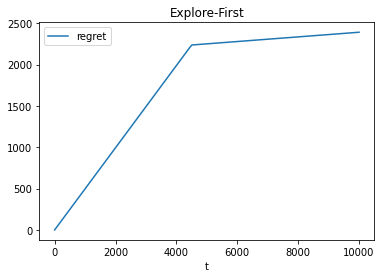

In [ ]:
# DO NOT MODIFY
np.random.seed(SEED)
ef_df = run_repeated_experiments(ExploreFirst, SEED)
ef_df.plot(x='t', y='regret', title='Explore-First')

### Problem 2
(3 points) 

Implement the $ \epsilon_t $-*Greedy* algorithm (**Algorithm 1.2** in [Bandits]) within the provided bandit algorithm template below. Use $\epsilon_t = \min \left\{1,\ t^{-1/3} \cdot (K \log t)^{1/3}\right\} $.

In [ ]:
class EpsilonTGreedy(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        self.T = T
        self.K = K
        #self.reward_list = [[0,0]]*K
        self.reward_list = np.zeros((K,2),dtype="int32")
        self.eps = 0
        self.t = 0
      

        pass
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        # FILL IN CODE HERE
        toss = st.bernoulli.rvs(1-self.eps)
       # print(toss)
        if toss:
            return np.random.randint(K)
        else:
            average_reward_list = []
            #print(self.reward_list)
            for i in range(len(self.reward_list)):
                if self.reward_list[i,0] == 0:
                  #  print("random",i)
                    average_reward_list.append(0)
                else:
                    visits = self.reward_list[i,0]
                  #  print("exploit",i)
                    avg_reward = self.reward_list[i,1]
                    average_reward_list.append(avg_reward/visits)
                    
           # average_reward_list = [reward / visits for [visits,reward] in self.reward_list
           #                                        if visits > 0 else 0]
            
            return np.argmax(average_reward_list)
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        
        # FILL IN CODE HERE
        self.t += 1
        self.eps = min(1,self.t**(-1/3)*(self.K*np.log(self.t))**(1/3))
        #print("eps:",self.eps)
        self.reward_list[action,0] += 1
        self.reward_list[action,1] += reward

Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The plot should show sublinear regret with respect to $t$.

<AxesSubplot:title={'center':'Epsilon_t-Greedy'}, xlabel='t'>

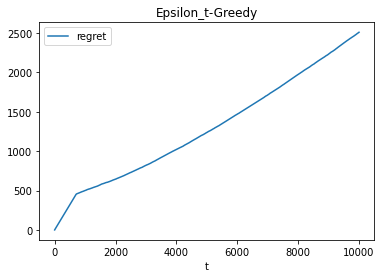

In [ ]:
# DO NOT MODIFY
np.random.seed(SEED)
eg_df = run_repeated_experiments(EpsilonTGreedy, SEED)
eg_df.plot(x='t', y='regret', title='Epsilon_t-Greedy')

### Problem 3
(3 points) 

Implement the UCB1 algorithm (**Algorithm 1.5** in [Bandits]) within the provided bandit algorithm template below.

In [ ]:
class UCB1(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        
        self.T = T
        self.K = K
        self.reward_list = np.zeros((K,2),dtype="int32")
        self.action_counter = -1
        pass
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        # FILL IN CODE HERE

        self.action_counter += 1
        if self.action_counter < self.K:
            return self.action_counter

        average_reward_list = []
        for i in range(len(self.reward_list)):
                if self.reward_list[i,0] == 0:
                  #  print("random",i)
                    average_reward_list.append(0)
                else:
                    visits = self.reward_list[i,0]
                  #  print("exploit",i)
                    avg_reward = self.reward_list[i,1]
                    average_reward_list.append(avg_reward/visits)

        confidence_bounds = [np.sqrt(2*np.log(T)/self.reward_list[a,0]) for a in range(self.K)]
        UCB = [average_reward_list[a] + confidence_bounds[a] for a in range(self.K)]

        return np.argmax(UCB)
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        
        # FILL IN CODE HERE
        self.reward_list[action,0] += 1
        self.reward_list[action,1] += reward
        pass

Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The plot should show sublinear regret with respect to $t$.

<AxesSubplot:title={'center':'UCB1'}, xlabel='t'>

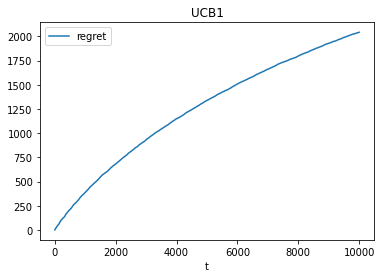

In [ ]:
# DO NOT MODIFY
np.random.seed(SEED)
ucb1_df = run_repeated_experiments(UCB1, SEED)
ucb1_df.plot(x='t', y='regret', title='UCB1')

### Problem 4
(9 points) 

This theory problem is based on **Exercise 1.1** in [Bandits]. The proofs in **Chapter 1** consider environments where the rewards are in the interval $[0,1]$. Consider the case when we have additional knowledge about about the problem and that we know that the rewards for each action are in the interval $\left[\frac{1}{2}, \frac{1}{2} + \epsilon\right]$ for some fixed $\epsilon \in \left(0, \frac{1}{2}\right)$. 

Consider a version of $\text{UCB1}$ modified to utilize this knowledge (you do not need to specify the algorithm completely, just define the new confidence radius $r_t(a)$). For this algorithm and problem setting, prove that:

$\mathbb{E}\left[R(t)\right] \leq \frac{2 t}{T^2} + 2 \epsilon \sqrt{2 K t \log T}$

**Hint:** Use a version of Hoeffding Inequality with ranges (**Theorem A.2** in the [Bandits] book) to modify the confidence radius $r_t(a)$. Subsequently follow the steps of the analysis leading up to **Theorem 1.14** in [Bandits] to derive the regret bound, though show the actual constants instead of using big O notation:

1. Define the clean event, like in **Section 1.3.1**, and bound the probability of the event.
2. Start with the definition of the regret $\mathbb{E}\left[R(t)\right]$, and perform a regret decomposition like on **Page 11** of **Section 1.3.2**.
3. Bound the *gap* $\Delta (a)$, like in **Section 1.3.3**.
4. Complete the proof using the technique on **Page 12** of **Section 1.3.2**.

*Write the solution in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

#### Solution

##### Calculating the new confidence radius

From A.2 a):

$$X_i \in [a_i,b_i] \quad \forall \, i \in [n], \: and \quad \beta = \dfrac{1}{n} \sum_{i \in [n]} (b_i - a_i)^2$$

In our case the bounds are $X_i \in [\frac{1}{2},\frac{1}{2} + \epsilon]$, so $a_i = \frac{1}{2}, b_i = \frac{1}{2} + \epsilon$

The Hoeffding inequality holds for the bounds given $\beta$ above.

Inserting $\alpha = 2$ and $\beta$ as above, the new confidence radius becomes $r_n = \sqrt{\frac{\alpha \beta \, log \, T}{n}} = \sqrt{\frac{2\sum_{n} (\epsilon^2) \: log \, T}{n^2}} = \sqrt{\frac{2\epsilon^2 \: log \, T}{n}}$

##### 1. Deriving the clean event and bound of probability

$$\mathrm{Pr}(|\bar v_j(a) - \mu (a)| \leq r_t(a)) \geq 2e^{-\frac{2t^2}{\sum_{i=1}^n (b_i-a_i)^2}} = 2e^{-\frac{2t^2}{n\epsilon^2}} $$

##### 2. Regret decomposition

$$\mathbb{E}[R(t)] = \mathbb{E}[R(t)|\mathrm{clean \; event}] \times \mathrm{Pr[clean \; event]} + \mathbb{E}[R(t)|\mathrm{bad \; event}] \times \mathrm{Pr[bad \; event]} $$

## Bayesian Bandits (Chapter 3)

### Problem 5
(3 points)

Implement the *Thompson Sampling* algorithm (**Algorithm 3.3** in [Bandits]) within the provided bandit algorithm template below. Assume independent priors and that the prior is $\mathbb{P} = \text{Beta}(\alpha_0, \beta_0)$ with $\alpha_0 = 1$ and $\beta_0 = 1$ (i.e. the **Beta-Bernoulli** setting, on **page 35** in [Bandits]).

**Note:** There is a typo in the expression for the posterior $\mathbb{P}_H$ in [Bandits]. It should be $\text{Beta}(\alpha_0 + \text{REW}_H,\ \beta_0 + t - \text{REW}_H)$.

In [ ]:
class ThompsonSampling(BanditAlgorithmBase):
    def __init__(self, T, K):
        """
        Constructor of the bandit algorithm

        Parameters
        ----------
        T : int
            Horizon
        K : int
            Number of actions
        """
        
        # FILL IN CODE HERE
        self.alpha = np.ones((K,1),dtype="int32")
        self.beta = np.ones((K,1),dtype="int32")

        pass
    
    def select_action(self):
        """
        Select an action which will be performed in the environment in the 
        current time step

        Returns
        -------
        An action index (integer) in [0, K-1]
        """
        
        # FILL IN CODE HERE
        
        max_mean = 0
        for i in range(len(self.alpha)):
            mean = st.beta.rvs(self.alpha[i],self.beta[i])
            if mean > max_mean:
                max_mean = mean
                arm = i
        return arm
    
    def update(self, action, reward):
        """
        Update the bandit algorithm with the reward received from the 
        environment for the action performed in the current time step

        Parameters
        ----------
        action : int
            An action index (integer) in [0, K-1]
        reward : int
            Reward (integer) in {0, 1} (Bernoulli rewards)

        """
        
        # FILL IN CODE HERE
        self.alpha[action] += reward
        self.beta[action] += 1 - reward
        pass

Run the algorithm in the provided environment using the code below (averaging regret over 5 runs). The plot should show sublinear regret with respect to $t$.

<AxesSubplot:title={'center':'Thompson Sampling'}, xlabel='t'>

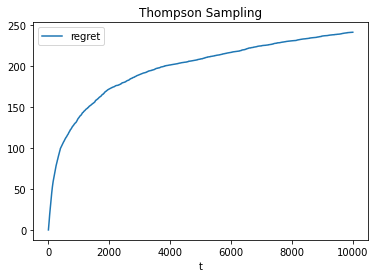

In [ ]:
# DO NOT MODIFY
np.random.seed(SEED)
ts_df = run_repeated_experiments(ThompsonSampling, SEED)
ts_df.plot(x='t', y='regret', title='Thompson Sampling')

### Problem 6
(3 points)

In this theory problem, you will show an intermediary step in the proof for the Bayesian regret bound of *Thompson Sampling* in the [Bandits] book.

Use the confidence radius and confidence bounds from (3.13). You may assume that properties (3.14) and (3.15) hold for these with $\gamma = 2$ (you do not have to prove this). Given that **Lemma 3.11** holds (i.e. that the Bayesian regret of *Thompson Sampling* is bounded such that $\text{BR}(T) \leq 2\gamma + 2 \sum_{t=1}^T \mathbb{E}\left[r(a_t, H_t)\right]$), show that:

$$ \text{BR}(T) \leq O\left(\sqrt{\log T}\right) \sum_{t=1}^T \mathbb{E}\left[\frac{1}{\sqrt{n_t(a_t)}}\right] $$

**Note:** This task is fairly straightforward, the purpose is to demonstrate comprehension of the material.

*Write the solution in the Markdown cell below (use LaTeX-math mode for equations, etc.).*

#### Solution

Confidence radius:

$$ r_t(a) = \sqrt{2*\frac{log(T)}{n_t(a_t)}}$$

$$ \text{BR}(T) \leq 2\gamma + 2\sum_{t=1}^T \mathbb{E} \left[r(a_t, H_t)\right]$$

Inserting gamma = 2 and the confidence radius:

$$ \text{BR}(T) \leq 4 + 2\sum_{t=1}^T \mathbb{E} \left[\sqrt{2*\frac{\log T}{n_t(a_t)}}\right]$$

Move constants out of expectation and summation:

$$ \text{BR}(T) \leq 4 + 2\sqrt{2 \, \log T}\sum_{t=1}^T \mathbb{E} \left[\frac{1}{\sqrt{n_t(a_t)}}\right]$$

Do big-O notation:

$$ \text{BR}(T) \leq O\left(\sqrt{\log T}\right)\sum_{t=1}^T \mathbb{E} \left[\frac{1}{\sqrt{n_t(a_t)}}\right]$$

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0c30810f-bb18-49c3-9881-ab491b995d80' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>